In [1]:
import json
import glob
import os
import pandas as pd
import numpy as np
# from scipy.sparse import hstack
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import ast
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import torch
import re
import os
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()
client = OpenAI() 

/Users/conor/Documents/CISC500- Individual Thesis/conor-repo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DF processing

In [2]:
df= pd.read_csv('data/pull_requests_filtered_raw.csv')
df['comments'] = df['comments'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['review_comments'] = df['comments'].apply(lambda comments: [item for item in comments if item['type'] != 'issue'] if type(comments) is not float else comments)
df = df[df['review_comments'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
df['issue_comments'] = df['comments'].apply(lambda comments: [item for item in comments if item['type'] != 'review'] if type(comments) is not float else comments)
df = df[df['issue_comments'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
df.shape

(3389, 17)

In [3]:
def extract_text(comment_thread):
    conversation = []
    for comment in comment_thread:
        main_comment = comment.get('comment', {}).get('body', '')
        
        # Extract replies' bodies
        replies = comment.get('replies', [])
        reply_bodies = [reply.get('body', '') for reply in replies]
        
        # Combine the main comment and all replies into one string
        combined_text = "Thread:\n" + main_comment + "\nReplies:\n" + "\n".join(reply_bodies)
        url_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
        
        combined_text = re.sub(url_pattern, "[link]", combined_text)
        combined_text = re.sub("```.*?```", "[code]", combined_text, flags=re.DOTALL)
        conversation.append(combined_text)
        
    return conversation
# Apply the function to extract text from the comments column
df['processed_comments_review'] = df['review_comments'].apply(extract_text)
print(df['processed_comments_review'].iloc[1])
df['processed_comments_issue'] = df['issue_comments'].apply(extract_text)
print(df['processed_comments_issue'].iloc[1])

["Thread:\n[code]\nReplies:\nThis are glob pattern not regexes, so the {6} doesn't work afaik. The [0-9] appears to be fine though. ", 'Thread:\n[code]\nReplies:\n', 'Thread:\n[code]\nReplies:\n', "Thread:\nMay be parametrize some hostnames to make sure all regex expressions are tested.\nReplies:\nI don't understand? I mean we are not evaluating the glob patterns here anyways, so we are just passing through the strings here. \nIt's not a bad idea though (added it)"]
['Thread:\nDo we need a docs PR here?\nReplies:\n', 'Thread:\n> Do we need a docs PR here?\r\n\r\nI added a note to docs.\nReplies:\n']


In [4]:
def clean_comments(comments):
    try:
        combined_text = " ".join(comments)
        return combined_text
    except (ValueError, SyntaxError):
        return ""

# Apply the function to the dataset
df['processed_comments_review'] = df['processed_comments_review'].apply(clean_comments)
df['processed_comments_issue'] = df['processed_comments_issue'].apply(clean_comments)


In [5]:
df.to_csv('prs_adjusted.csv')

# Sentence bert

In [6]:
#sentence bert
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_r = model.encode(df['processed_comments_review'].tolist(), normalize_embeddings=True)
similarity_matrix_r = cosine_similarity(embeddings_r)
embeddings_i = model.encode(df['processed_comments_issue'].tolist(), normalize_embeddings=True)
similarity_matrix_i = cosine_similarity(embeddings_i)

In [7]:
def normalize_embeddings(embeddings):

    return normalize(embeddings, norm='l2')

# Apply normalization before clustering
embeddings_r = normalize_embeddings(embeddings_r)
embeddings_i= normalize_embeddings(embeddings_i)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


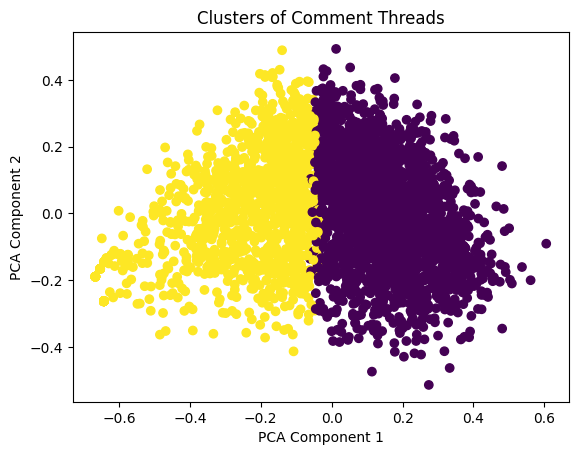

In [8]:
num_clusters = 2  # Adjust based on your expectation or use methods like the elbow method
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings_r)
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_r)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis')
plt.title("Clusters of Comment Threads")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [9]:
from sklearn.cluster import DBSCAN

def apply_dbscan(embeddings, eps=0.5, min_samples=5):
   
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    cluster_labels = dbscan.fit_predict(embeddings)
    return cluster_labels

# Example usage with BERT/SBERT embeddings
dbscan_clusters = apply_dbscan(embeddings_r,eps=0.3, min_samples=5)
print(len(set(dbscan_clusters))-1)


8


In [10]:
cluster_counts = pd.DataFrame(
    np.unique(dbscan_clusters, return_counts=True), 
    index=["Cluster", "Count"]
).T.sort_values("Count", ascending=False)

print(cluster_counts)


   Cluster  Count
0       -1   2538
1        0    810
2        1      8
3        2      8
4        3      6
5        4      5
7        6      5
8        7      5
6        5      4


PCA Reduction Completed. Shape: (3389, 2)


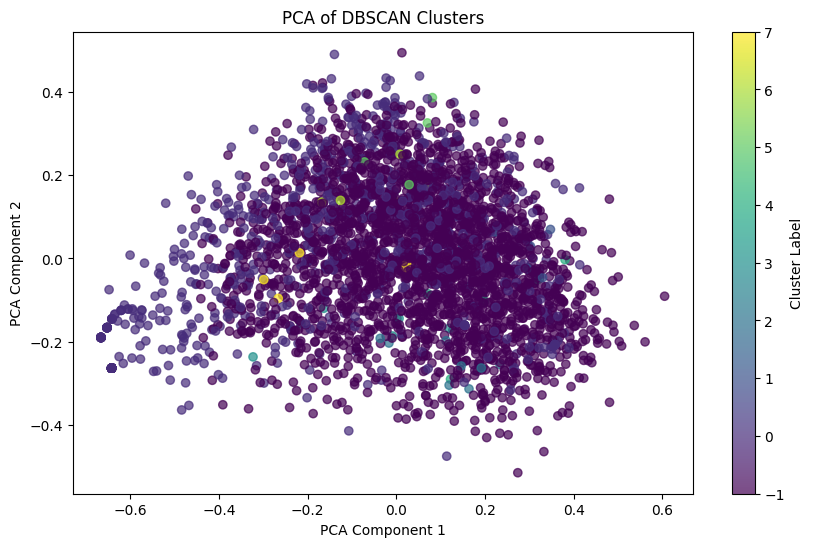

In [11]:

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings_r)
print("PCA Reduction Completed. Shape:", pca_embeddings.shape)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=dbscan_clusters, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")
plt.title("PCA of DBSCAN Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Generic bert

In [12]:
#generic bert
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to(device)

In [13]:
device

device(type='cpu')

In [14]:
def get_bert_embedding(text):
    # Tokenize the input and move inputs to the GPU
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token embedding as the sentence embedding
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # Move output back to CPU
    return embedding


In [9]:
embeddings_review = df['processed_comments_review'].apply(get_bert_embedding).tolist()
embeddings_issue = df['processed_comments_issue'].apply(get_bert_embedding).tolist()


In [ ]:
# Check for mismatched shapes
embedding_lengths = [len(e) if isinstance(e, (list, np.ndarray, torch.Tensor)) else 0 for e in embeddings_issue]
print(embedding_lengths)  # List of lengths of each embedding

In [ ]:
def remove_markers(text):
    # Remove "Thread" and "Reply" markers
    text = re.sub(r"Thread:\s*", "", text, flags=re.IGNORECASE)
    text = re.sub(r"Replies:\s*", "", text, flags=re.IGNORECASE)
    
    return text.strip()

# Apply the function to remove markers
df['clustering_comments_review'] = df['processed_comments_review'].apply(remove_markers)
df['clustering_comments_issue'] = df['processed_comments_issue'].apply(remove_markers)


In [ ]:
df['clustering_comments_issue']

In [17]:
scaler = StandardScaler()

embeddings_tensor_r = torch.tensor(embeddings_review, dtype=torch.float32).to(device)
normalized_embeddings_r = torch.tensor(scaler.fit_transform(embeddings_tensor_r.cpu().numpy())).to(device)

embeddings_tensor_i = torch.tensor(embeddings_issue, dtype=torch.float32).to(device)
normalized_embeddings_i = torch.tensor(scaler.fit_transform(embeddings_tensor_i.cpu().numpy())).to(device)


# Clustering

In [21]:
def torch_kmeans(data, k, max_iters=300):
    # Randomly initialize cluster centroids
    centroids = data[torch.randperm(data.size(0))[:k]].clone()

    for _ in range(max_iters):
        # Assign each point to the nearest cluster centroid
        distances = torch.cdist(data, centroids)
        cluster_assignments = torch.argmin(distances, dim=1)

        # Update centroids
        new_centroids = torch.stack(
            [data[cluster_assignments == c].mean(dim=0) for c in range(k)]
        )
        
        # Check for convergence
        if torch.allclose(centroids, new_centroids, atol=1e-4):
            break

        centroids = new_centroids

    return cluster_assignments, centroids

In [ ]:
# Function to calculate inertia for different numbers of clusters
def elbow_method(embeddings, max_k=10):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        inertia.append(kmeans.inertia_)
    return inertia

# Calculate inertia values
inertia_values = elbow_method(embeddings_r, max_k=50)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 51), inertia_values, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 51))
plt.grid()
plt.show()

In [ ]:
def find_best_k(embeddings, min_k=2, max_k=200):
    silhouette_scores = []
    k_values = range(min_k, max_k+1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels)
        silhouette_scores.append(score)

    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score for Optimal k")
    plt.show()

    best_k = k_values[np.argmax(silhouette_scores)]
    print(f"Best k (Highest Silhouette Score): {best_k}")
    return best_k

# Use this function on your normalized embeddings
best_k = find_best_k(embeddings_r)

In [ ]:
num_clusters = 2
cluster_assignments, centroids = torch_kmeans(embeddings_r, num_clusters)


df['cluster_review'] = cluster_assignments.cpu().numpy()

In [ ]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_r.cpu().numpy())

# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster_id in range(num_clusters):
    cluster_points = reduced_embeddings[cluster_assignments.cpu().numpy() == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

plt.title("KMeans Clustering Visualization with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# Labels

In [ ]:
for cluster_id in range(num_clusters):  
    print(f"\nCluster {cluster_id}:")
    samples = df[df['cluster'] == cluster_id]['clustering_comments'].head(5)  # Adjust the column name as needed
    for sample in samples:
        print(f"- {sample}")


In [ ]:
def get_top_keywords(texts, n=10):
    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(texts)
    keywords = vectorizer.get_feature_names_out()
    keyword_counts = X.sum(axis=0).A1
    sorted_keywords = sorted(zip(keywords, keyword_counts), key=lambda x: x[1], reverse=True)
    return [keyword for keyword, _ in sorted_keywords[:n]]

# Get top keywords for each cluster
for cluster_id in range(num_clusters):
    cluster_texts = df[df['cluster'] == cluster_id]['clustering_comments']
    keywords = get_top_keywords(cluster_texts)
    print(f"\nCluster {cluster_id} Keywords: {keywords}")

In [ ]:
for cluster_id in range(num_clusters):
    cluster_texts = df[df['cluster'] == cluster_id]['clustering_comments']
    body = get_top_keywords(cluster_texts)
    
    chat_response = client.chat.completions.create(
    model="gpt-4o",
    temperature=0.2,
    messages=[
    {
        "role": "system",
        "content": (
            "You are a helpful assistant that can label clusters based on its top keywords."
        ),
    },
    {
        "role": "user",
        "content": (
            f"Here are some top keywords from some clusters, please label them: {body}"
            
        ),
    },
]


)

# Extract and clean the response
response_text = chat_response.choices[0].message.content

print(response_text)

# playground

In [22]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
text_features = vectorizer.fit_transform(df['comment'])

In [ ]:
df['comment_type_encoded'] = LabelEncoder().fit_transform(df['comment_type'].fillna(""))
df['is_code_owner_encoded'] = df['is_code_owner'].fillna(0).astype(int)
df['author_is_code_owner_encoded'] = df['author_is_code_owner'].fillna(0).astype(int)

In [ ]:
metadata_features = df[['comment_type_encoded', 'is_code_owner_encoded', 'author_is_code_owner_encoded']].values
combined_features = hstack([text_features, metadata_features])
df.head()

In [ ]:
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [29]:
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(combined_features)

In [ ]:
print(df['cluster'].value_counts())

In [ ]:
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_data = df[df['cluster'] == cluster]
    print(cluster_data['comment'].head(5))  # Example comments
    print(cluster_data[['comment_type', 'is_code_owner', 'author_is_code_owner']].describe())

In [ ]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(combined_features.toarray())


plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('k-means Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()